$ Learning LSTM $ <br>
 使用LSTM 預測股價 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [3]:
import yfinance as yf
from talib import abstract

stk = yf.Ticker('SPY')
# 取得 1995 年至今的資料
data = stk.history(start = '1995-01-01')
# 簡化資料，只取開、高、低、收以及成交量
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = ['open','high','low','close','volume']
data

dataset : 輸入訓練資料 <br>
target : 預測資料 <br>
start_index : 起始點 通常為0 因為後續自己會分組. <br>
end_index : 終點 設0 <br>
history_size 輸入長度 本文選10 target_size 預測長度 本文選1 <br>

In [5]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))
###計算Rmse
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
    
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)

*Dropout* 防止過擬合，從0~1之間去調整 <br>
input length 為輸入的時間長度，本文選用10天 <br>
input_dim 為變數數量，本文總共有5個變數 <br>
return_sequences : True 為維持 (batch ,time_steps ,seq_len) ，連接下一層LSTM 設置 False 將會變成一維 <br>
loss 使用mean_squared_error訓練，Optimizer 使用  <br>

In [6]:
def build_model(input_length, input_dim):
    d=0.3
    model= Sequential()
    model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=True))
    
    model.add(Dropout(d))
    
    model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=False))
    
    model.add(Dropout(d))
    
    model.add(Dense(1,activation='linear'))
#linear / softmax(多分類) / sigmoid(二分法)
    
    model.compile(loss='mse',optimizer='adam')
    return model

In [7]:
y = data["close"]
x = data

x


,open,high,low,close,volume
Date,,,,,
1995-01-03,27.849108,27.934798,27.839587,27.896713,324300
1995-01-04,28.020487,28.030008,27.877671,28.030008,351800
1995-01-05,28.049050,28.096656,28.001445,28.030008,89800
1995-01-06,28.087121,28.182331,27.972868,28.058558,448400
1995-01-09,28.049047,28.087132,28.030005,28.087132,36800
...,...,...,...,...,...
2022-08-23,412.899994,415.420013,411.769989,412.350006,49105200
2022-08-24,412.109985,415.109985,411.390015,413.670013,49177800
2022-08-25,415.239990,419.559998,414.089996,419.510010,50942300


資料正規化，讓資料變成0~1之間，讓資料訓練速度更快，且更容易收斂

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(y.to_frame())
scaler1=MinMaxScaler(feature_range=(0,1))
x=scaler1.fit_transform(x)

將資料分成訓練組，驗證組，測試組

In [9]:
x,y=multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
split =0.95
x_,y_  = x[0:int(split*len(x))] , y[0:int(split*len(x))]
x_test ,y_test   = x[int(split*len(x)):] , y[int(split*len(x)):]

split= 0.8
x_train,y_train  =x_[:int(split*len(x_))] , y_[:int(split*len(x_))]
x_vaild,y_vaild  =x_[int(split*len(x_)):] , y_[int(split*len(x_)):]

In [10]:
def lstm_model0(input_length, input_dim):

    d = 0.3
    model = Sequential()
    model.add(LSTM(32, input_shape = (input_length, input_dim), return_sequences = False))
    model.add(Dropout(d))

    model.add(Dense(1, activation = 'linear')) #linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss = 'mse', optimizer = 'adam') # loss = mse/categorical_crossentropy
    return model

EarlyStopping : 在訓練組訓練參數，以驗證組最低為選擇標準，如果300個epochs，沒有改善即停止訓練 <br>
filepath : 模型儲存路徑 <br>
ModelCheckpoint : 選擇val_loss最低的當作最後的模型 <br>
batch 是每次訓練抽取樣本數 <br>
epochs 訓練次數 <br>
shuffle True 隨機打亂 False 不打亂排序 <br>

In [11]:
my_callbacks = [
tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
] ######## 在訓練組訓練，使用驗證組選取

filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)
call_backlist = [my_callbacks,checkpoint]
lstm00 = lstm_model0(10,5) 
historylstm0 = lstm00.fit( x_train, y_train, batch_size=30, shuffle=False , epochs=1000, validation_data=(x_vaild,y_vaild), callbacks=call_backlist)
lstm00.summary()

Epoch 1/1000
172/177 [============================>.] - ETA: 0s - loss: 4.1210e-04
Epoch 1: val_loss improved from inf to 0.01919, saving model to lstm.best.hdf5
177/177 [==============================] - 3s 6ms/step - loss: 4.3427e-04 - val_loss: 0.0192
Epoch 2/1000
164/177 [==========================>...] - ETA: 0s - loss: 7.1971e-04
Epoch 2: val_loss improved from 0.01919 to 0.01091, saving model to lstm.best.hdf5
177/177 [==============================] - 1s 4ms/step - loss: 7.6399e-04 - val_loss: 0.0109
Epoch 3/1000
164/177 [==========================>...] - ETA: 0s - loss: 6.1180e-04
Epoch 3: val_loss improved from 0.01091 to 0.00611, saving model to lstm.best.hdf5
177/177 [==============================] - 1s 4ms/step - loss: 6.5152e-04 - val_loss: 0.0061
Epoch 4/1000
173/177 [============================>.] - ETA: 0s - loss: 2.8756e-04
Epoch 4: val_loss improved from 0.00611 to 0.00539, saving model to lstm.best.hdf5
177/177 [==============================] - 1s 4ms/step - loss

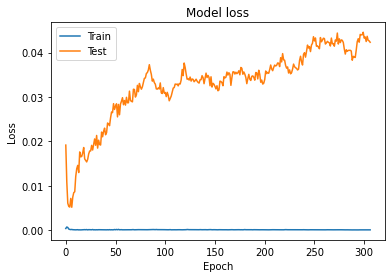

In [12]:
#繪製 訓練情形
plt.plot(historylstm0.history['loss'])
plt.plot(historylstm0.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

42/42 [==============================] - 0s 2ms/step


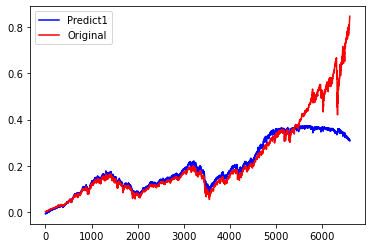

In [13]:
lstm0train  = lstm00.predict(x_train)
lstm0val = lstm00.predict(x_vaild)
lstm0pre = lstm00.predict(x_test)
pre = lstm00.predict(x_train)
pre1=lstm00.predict(x_vaild)
fc=np.concatenate((pre,pre1))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')
plt.legend()
plt.show()

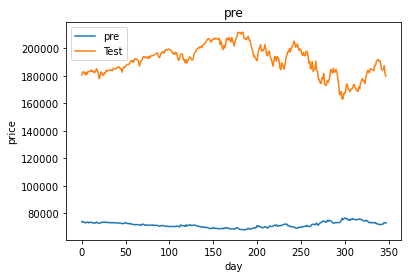

119907.21342366324

In [15]:
lstm0pre= scaler.inverse_transform(lstm0pre)#將資料轉換回來
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
plt.figure()
plt.plot(lstm0pre)
plt.plot(y_test)
plt.title('pre')
plt.ylabel('price')
plt.xlabel('day')
plt.legend(['pre', 'Test'], loc='upper left')
plt.show()
root_mean_squared_error(lstm0pre,y_test)